<a href="https://colab.research.google.com/github/Baxi-codes/QMLHEP-tasks/blob/main/QML_HEP_GSoC_Task_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QML-HEP GSoC 2023 Task-II  Classical Graph Neural Network

This is the jupyter notebook containing task II for QMLHEP GSOC 2023

## Task
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description. 
* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
* Discuss the resulting performance of the 2 chosen architectures. 

## Dataset
The dataset given for the task is Pythia8 Quark and Gluon Jets for Energy Flow[1][2].The dataset consists of two sets of quark and gluon jets generated using Pythia 8, a Monte Carlo event generator widely used in particle physics simulations.

It contains 20 files, each in compressed NumPy format. Each file contains two arrays:

* X: A (100000, M, 4) array, where M is the maximum multiplicity of the jets in that file. The array contains exactly 50,000 quark and 50,000 gluon jets, randomly sorted. Each particle within a jet is represented by its transverse momentum (pt), rapidity, azimuthal angle, and particle ID (pdgid). For jets with fewer than M particles, zero-particles have been padded to ensure a consistent shape.

* y: A (100000,) array of labels for the jets. The labels indicate whether the jet is a gluon (0) or a quark (1).



In [ ]:
!wget https://zenodo.org/record/3164691/files/QG_jets.npz
!wget https://raw.githubusercontent.com/hqucms/ParticleNet/master/tf-keras/tf_keras_model.py

--2023-03-27 17:50:12--  https://zenodo.org/record/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  3.63MB/s    in 43s     

2023-03-27 17:50:58 (2.35 MB/s) - ‘QG_jets.npz’ saved [106689379/106689379]

--2023-03-27 17:50:58--  https://raw.githubusercontent.com/hqucms/ParticleNet/master/tf-keras/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7583 (7.4K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   7.41K  --.-KB/s   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tf_keras_model import get_particle_net_lite, get_particle_net
from tensorflow import keras
%matplotlib inline

In [ ]:
with np.load('./QG_jets.npz') as data:
  X = data['X']
  y = data['y']

## Projection of Data to graph
Jets are commonly observed in proton-proton collisions at the LHC and can be described as a focused burst of particles. To analyze jet data, it can be represented as a particle cloud similar to how 3D shapes are represented as point clouds in computer vision. Due to the symmetrical arrangement of the particles in the cloud, it is a useful and promising way to represent jets.

In this task, we use particle net's implementation of DGCNN to classify the quark/gluon jets. The implementation uses K Nearest neighbors(KNN) using the spatial coordinates of the particles in the pseudorapidity-azimuth space i.e. Pseudo-Rapidity, Azimuthal Angle, and Transverse Momentum as given in the dataset.
Pseudorapidity-azimuth space is a mathematical space used to describe the distribution of particles produced in a high-energy particle collision. Pseudorapidity is a dimensionless quantity that measures the angle between the momentum vector of a particle and the beam axis, while azimuthal angle is the angle between the projection of the particle's momentum vector onto the transverse plane and a reference direction.


In [ ]:
from IPython.display import clear_output
import os
import torch
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
clear_output()

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()


The points in pseudorapidity-azimuth space in the first jet can be visualized as

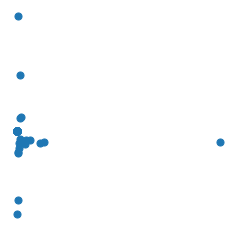

In [ ]:
example=X[0,:,:3]
visualize_points(example,None)

After we apply KNN to the first jet, here's what the resulting graph looks like

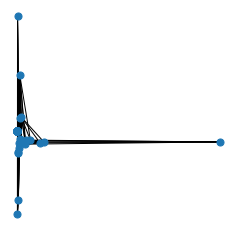

In [ ]:
from torch_cluster import knn_graph

example_G = knn_graph(torch.tensor(example), k=6)
visualize_points(example, edge_index=example_G)

## Architecture used
We use ParticleNet's Dynamic Graph Convolutional Neural Network(DGCNN) architecture[3][4]. 

ParticleNet is a neural network architecture designed to classify jets in particle physics experiments. The model represents a jet as an unordered set of its constituent particles, which is called a "particle cloud" representation. This representation is efficient in incorporating the raw information of the jet and also respects the permutation symmetry. The architecture of ParticleNet is based on the DGCNN, which is customized for jet tagging problems. ParticleNet achieves state-of-the-art performance on two representative jet tagging benchmarks and outperforms existing methods significantly.

### preprocessing the data

In [ ]:
random_seed = 4056

y = keras.utils.to_categorical(y)
X, _, y, __ = train_test_split(X, y, test_size=0.6, random_state=random_seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random_seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_seed)
# mask for train set
mask_train = np.sum(X_train, axis=2)
mask_train = np.array(mask_train != 0, np.float32)
mask_train = mask_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# mask for validation set
mask_val = np.sum(X_val, axis=2)
mask_val = np.array(mask_val != 0, np.float32)
mask_val = mask_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# mask for test set
mask_test = np.sum(X_test, axis=2)
mask_test = np.array(mask_test != 0, np.float32)
mask_test = mask_test.reshape(X_test.shape[0], X_test.shape[1], 1)

train_dataset = {
    'points': X_train[:, :, 1:3],
    'features': X_train,
    'mask': mask_train
}

test_dataset = {
    'points': X_test[:, :, 1:3],
    'features': X_test,
    'mask': mask_test
}

val_dataset = {
    'points': X_val[:, :, 1:3],
    'features': X_val,
    'mask': mask_val
}
shapes = {
    'points': X_train[:, :, 1:3].shape[1:],
    'features': X_train.shape[1:],
    'mask': mask_train.shape[1:]
}

### Initializing and compiling the model

In [ ]:
model = get_particle_net_lite(2, shapes)

batch_size = 1024
epochs = 40

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    return lr

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

### Training the model

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
particle_net_lite_history = model.fit(train_dataset, y_train, batch_size=batch_size, epochs=epochs, validation_data=(val_dataset, y_val), shuffle=True, callbacks=[lr_scheduler])

Epoch 1/40
28/28 [==============================] - 305s 11s/step - loss: 0.5580 - accuracy: 0.7294 - val_loss: 0.7946 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 2/40
28/28 [==============================] - 298s 11s/step - loss: 0.4930 - accuracy: 0.7694 - val_loss: 0.7162 - val_accuracy: 0.5047 - lr: 0.0010
Epoch 3/40
28/28 [==============================] - 308s 11s/step - loss: 0.4846 - accuracy: 0.7737 - val_loss: 0.6320 - val_accuracy: 0.5795 - lr: 0.0010
Epoch 4/40
28/28 [==============================] - 301s 11s/step - loss: 0.4812 - accuracy: 0.7753 - val_loss: 0.5835 - val_accuracy: 0.6663 - lr: 0.0010
Epoch 5/40
28/28 [==============================] - 313s 11s/step - loss: 0.4761 - accuracy: 0.7798 - val_loss: 0.5337 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 6/40
28/28 [==============================] - 301s 11s/step - loss: 0.4747 - accuracy: 0.7786 - val_loss: 0.5272 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 7/40
28/28 [==============================] - 309s 11s/step - lo

In [ ]:
import pandas as pd

# convert the particle_net_lite_history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(particle_net_lite_history.history) 

# save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### testing and evaluation

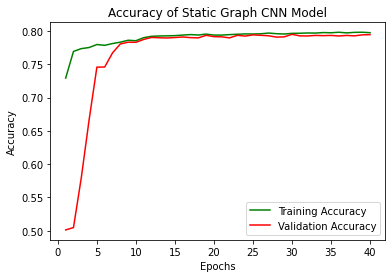

In [ ]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), particle_net_lite_history.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), particle_net_lite_history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Static Graph CNN Model")
plt.legend()
plt.show()

###

In [ ]:
loss, acc = model.evaluate(test_dataset, y_test)
print("Evaluation Metric of Dynamic Graph CNN Model on Test Dataset")
print("Loss:", loss)
print("Accuracy:", acc)

188/188 [==============================] - 11s 57ms/step - loss: 0.4623 - accuracy: 0.7880
Evaluation Metric of Dynamic Graph CNN Model on Test Dataset
Loss: 0.4623206853866577
Accuracy: 0.7879999876022339


## Conclusion
I used ParticleNet lite architecture to classify Quark/Gluon jets in the ParticleNet dataset. The DGCNN approach used by particlenet was able to effectively classify the jets with high accuracy. This demonstrates the effectiveness of graph-based architectures for processing complex data such as particle physics data.

## References


[1] [Komiske, Patrick;  Metodiev, Eric;  Thaler, Jesse; Pythia8 Quark and Gluon Jets for Energy Flow ](https://zenodo.org/record/3164691#.ZCHeENJBzZ4) \\
[2] Patrick T. Komiske, Eric M. Metodiev, Jesse Thaler: “Energy Flow Networks: Deep Sets for Particle Jets”, 2018, JHEP 01 (2019) 121; <a href='http://arxiv.org/abs/1810.05165'>arXiv:1810.05165</a>. DOI: <a href='https://dx.doi.org/10.1007/JHEP01(2019)121'>10.1007/JHEP01(2019)121</a>. \\
[3] https://github.com/hqucms/ParticleNet \\
[4] [Qu, H., & Gouskos, L. (2020). Jet tagging via particle clouds. Phys. Rev. D, 101, 056019](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.101.056019).
